# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [1]:
import os
import sys
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import annotate_spike, extract_template, find_spike_template
from facet.Epilepsy.template_utils import detect_spike_matches, plot_match_with_template, basic_clean, flag_muscle_ics
import scipy.stats as st
from scipy.signal import find_peaks

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))

logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

eegDataSet = "../datasets/test_epilepsy_eeg.edf"


f = facet()

2025-05-25 05:19:07.378 | ERROR    | facet.helpers.fastranc:<module>:23 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll does not exist. Run the build.py script to create the file.
2025-05-25 05:19:07.379 | ERROR    | facet.helpers.fastranc:<module>:40 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll could not be opened! Check your Project Files Message: Could not find module 'c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers\fastranc.dll' (or one of its dependencies). Try using the full path with constructor syntax.
2025-05-25 05:19:07.379 | INFO     | facet.helpers.fastranc:<module>:41 - Current working directory: g:\Medical Engineering and Analytics\Facetpy\FACETpy-main\FACETpy-main\examples\epilepsynotebooks


## Second Step import EEG Data and process

2025-05-25 05:19:09.888 | INFO     | facet.facet:import_eeg:33 - Importing EEG from ../datasets/test_epilepsy_eeg.edf


0.0003276342
{'F3': 'n/a', 'F4': 'n/a', 'C3': 'n/a', 'C4': 'n/a', 'P3': 'n/a', 'P4': 'n/a', 'O1': 'n/a', 'O2': 'n/a', 'F7': 'n/a', 'F8': 'n/a', 'T3': 'n/a', 'T4': 'n/a', 'T5': 'n/a', 'T6': 'n/a', 'Fz': 'n/a', 'Cz': 'n/a', 'Pz': 'n/a', 'A1': 'n/a', 'A2': 'n/a'}
[1. 1. 1. 1. 1.]
peak value (raw) : 0.0003276342
rms per channel  : [9.47758826e-05 9.39581287e-05 9.06525879e-05 3.13758126e-05
 9.43453961e-05 6.60782698e-05 9.42562119e-05 8.00400562e-05
 9.63007913e-05 9.55292157e-05 9.52826807e-05 9.05929063e-05
 9.15293896e-05 8.36554486e-05 7.83429420e-05 9.45392733e-05
 9.48378905e-05 9.27088090e-05 8.87525687e-05]
Adaptive reject threshold ≈ 1021.3 µV


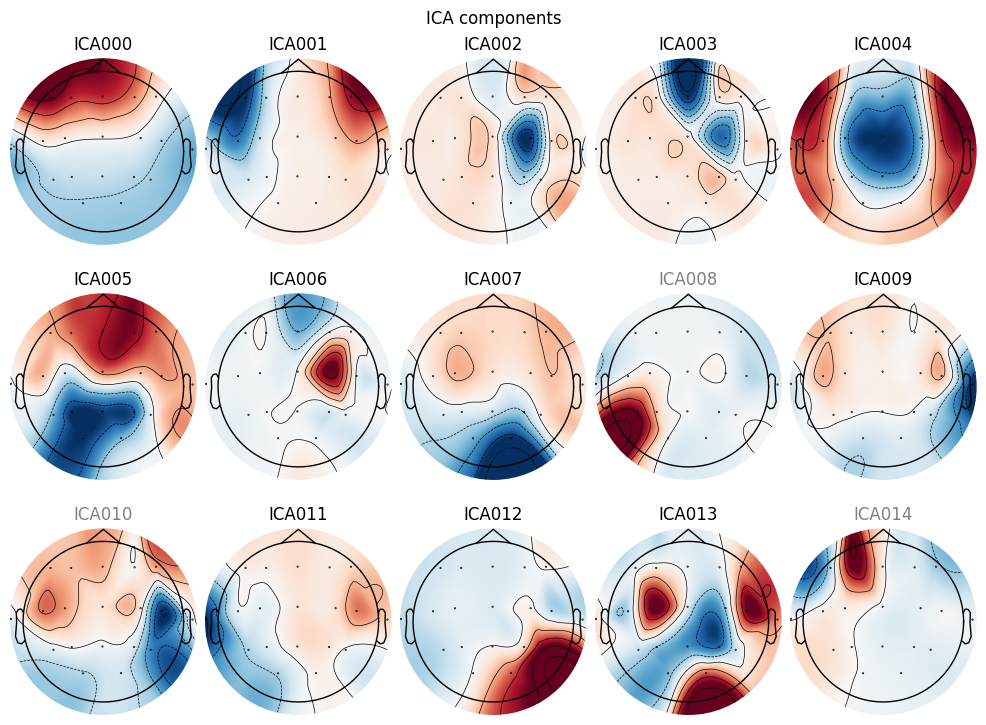

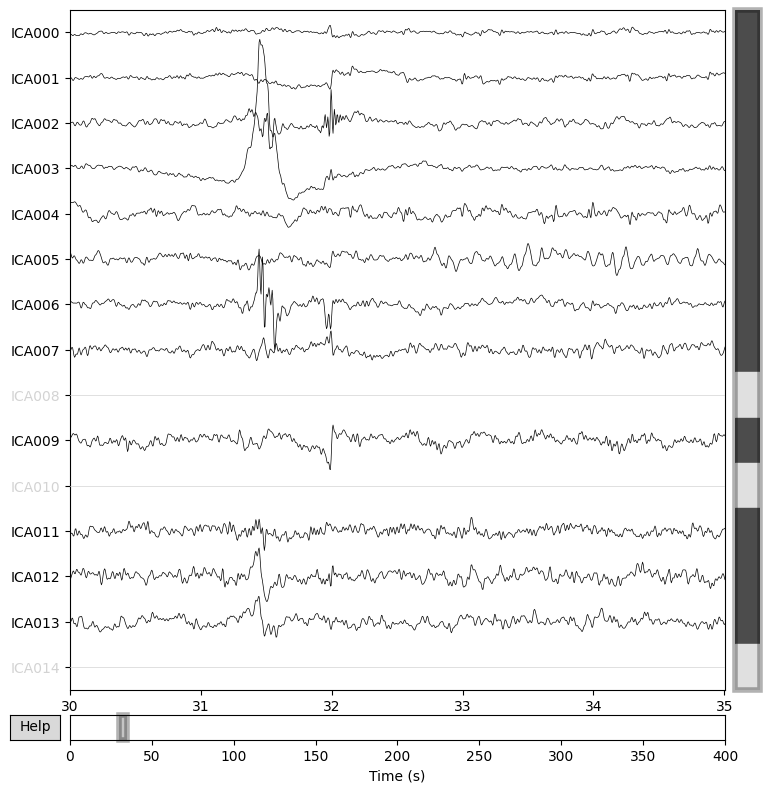

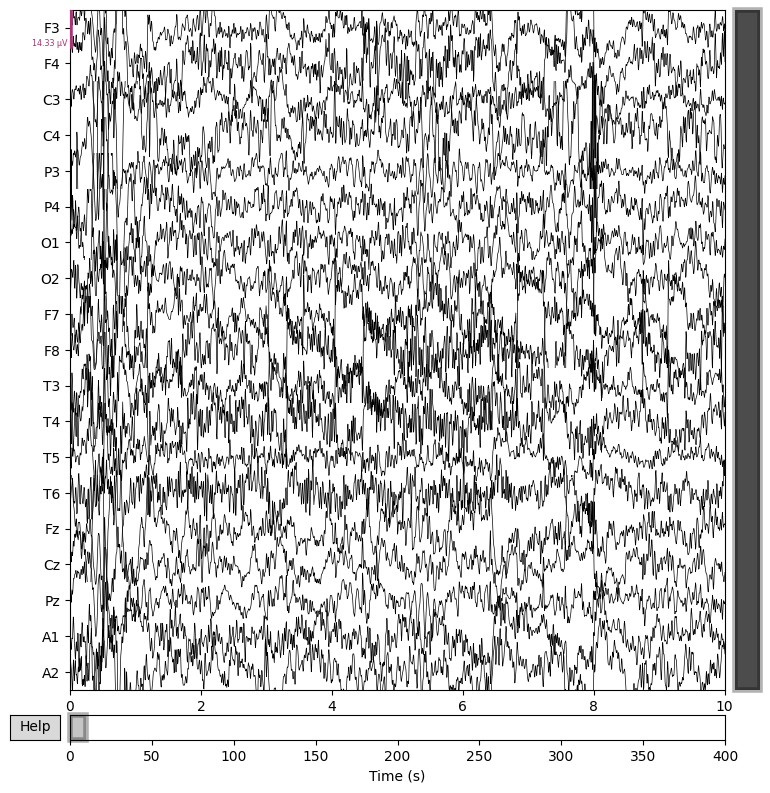

Measurement date,"September 13, 2023 14:22:23 GMT"
Experimenter,Unknown
Participant,<no
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [2]:
# Step 1 — Import EEG with FACET
f.import_eeg(eegDataSet, artifact_to_trigger_offset=-0.005, bads=["EMG", "ECG"])
raw = f.get_eeg().mne_raw
raw.set_montage('standard_1020', on_missing='warn')
raw._data *= 1e-6  
print(raw.get_data().max())        # ~3 ×10²  (µV)      <- BEFORE cleaning



# Quick unit check
print(raw._orig_units)               # usually gives {'EEG': 'uV'} or {'EEG': 'V'}
print(raw._cals[:5])                 # calibration factors per channel

print('peak value (raw) :', raw.get_data().max())
print('rms per channel  :', np.sqrt(np.mean(raw.get_data()**2, axis=1)))

# quick robust estimate of channel peak-to-peak
ptp = raw.get_data(reject_by_annotation='omit').ptp(axis=1) * 1e6  # µV
thr  = np.percentile(ptp, 99) * 1.5      # “just above” normal range
print(f'Adaptive reject threshold ≈ {thr:0.1f} µV')



# band-pass, notch, crop and ICA – all in one helper
raw_clean, ica = basic_clean(
        raw,
        l_freq    = 1. ,
        h_freq    = 40.,
        notch     = 50 ,
        crop_tmin = 10,     # skip first 10 s
        crop_tmax = 180,    # analyse up to 180 s
        ica_var   = 0.99,
        reject_uV = thr
)

ica.plot_components(inst=raw_clean)
ica.plot_sources(raw_clean, start=30, stop=35)
raw_disp = raw_clean.copy().filter(0.1, None, verbose=False)
raw_disp.plot(start=0, duration=10, scalings='auto')
ica.exclude = [0, 1, 4, 7]  # Add/remove based on visual inspection
ica.apply(raw_clean)

#raw_clean.plot(start=0, duration=10, scalings='auto')

# muscle_idx = flag_muscle_ics(ica, raw_clean, z_thresh=3.)
# ica.exclude += muscle_idx
# ica.apply(raw_clean)
# print("Muscle-type ICs removed:", muscle_idx)

# # final rereference and optional second, very mild high-pass just for display
# raw_clean.set_eeg_reference('average', projection=False)
# raw_disp = raw_clean.copy().filter(0.1, None, verbose=False)

# raw_disp.plot(start=0, duration=10, scalings='auto')   # traces
# raw_clean.plot_psd(fmax=45)                            # final PSD


# #  Inspect ICA
# ica.plot_components(inst=raw_clean)
# # For example: ica.exclude += [0, 1]
# # Then re-apply:
# ica.apply(raw_clean)

# # 4) sanity-check the result
# raw_clean.plot(start=0, duration=10, scalings='auto')
# raw_clean.plot_psd(fmax=45)

### ind most spiky IC

In [3]:
# 1) Rank ICs by kurtosis (spikes → high kurtosis)
import scipy.stats as st
ics = ica.get_sources(raw_clean).get_data()
kurt = [st.kurtosis(ics[i]) for i in range(ics.shape[0])]
best_ic = int(np.argmax(kurt))          # index of the spikiest component
print(f"Most-spiky IC ≈ ICA{best_ic:03d}  (kurtosis={kurt[best_ic]:.1f})")

Most-spiky IC ≈ ICA003  (kurtosis=183.1)


### Detect peaks in that IC and build a median template

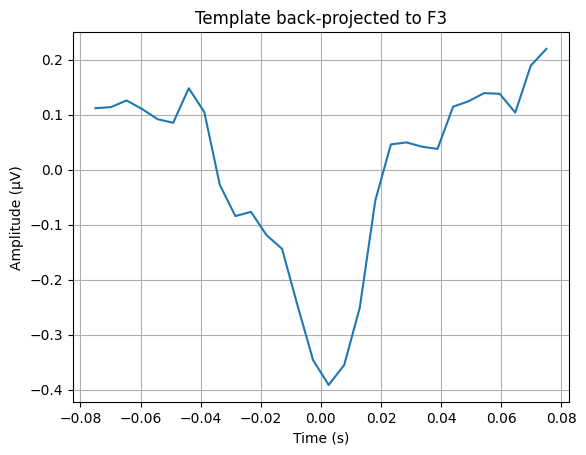

In [4]:
sig   = ics[best_ic]
sfreq = raw_clean.info['sfreq']
# find peaks ≥ 4× sd, min distance 200 ms
peaks, _ = find_peaks(np.abs(sig), height=4*sig.std(), distance=int(0.2*sfreq))

win  = int(0.15*sfreq)          # 150 ms window
snips = []
for p in peaks:
    if p-win//2 < 0 or p+win//2 > len(sig): continue
    snips.append(sig[p-win//2:p+win//2])
template_ic   = np.median(np.array(snips), axis=0)   # robust median template
template_ic  -= template_ic.mean(); template_ic /= template_ic.std()



# back-project one IC to sensors (mixing matrix column)
topo = ica.mixing_matrix_[:, best_ic]          # shape (n_channels,)
template_sensor = np.outer(topo, template_ic)       # outer product gives (n_chan, n_time)
# pick the sensor you want, e.g. F3
f3_idx = raw_clean.ch_names.index("F3")
template = template_sensor[f3_idx]

times = np.linspace(-0.075, 0.075, template.shape[0])  # Adjust window to match your spike window
plt.plot(times, template)
plt.title("Template back-projected to F3")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

## Cross correlation

In [5]:
channel_scores = {}
top_score = -np.inf
top_channel = None
top_time = None
raw_for_templates = raw_clean

for ch in raw.info['ch_names']:
    match_times, match_scores = detect_spike_matches(raw_for_templates, ch, template, threshold_ratio=0.8)
    channel_scores[ch] = len(match_times)

    # Check if this channel has a new highest score
    if match_scores:  # Make sure it's not empty
        max_idx = np.argmax(match_scores)
        if match_scores[max_idx] > top_score:
            top_score = match_scores[max_idx]
            top_channel = ch
            top_time = match_times[max_idx]

# Print sorted channels by match count
sorted_channels = sorted(channel_scores.items(), key=lambda x: x[1], reverse=True)
for ch, count in sorted_channels:
    print(f"{ch}: {count} matches")

# Print the best individual match overall
if top_time is not None:
    print(f"\nBest single match: {top_channel} at {top_time:.2f}s (score = {top_score:.2f})")
    plot_match_with_template(raw, top_channel, [top_time], template, raw.info["sfreq"])
else:
    print("\nNo spike match passed the threshold on any channel.")


match_times, match_scores = detect_spike_matches(raw, "F3", template, threshold_ratio=0.8)

# Sort scores to find best ones
top_matches = sorted(zip(match_times, match_scores), key=lambda x: x[1], reverse=True)

# Plot top 3 matches for visual inspection
for t, score in top_matches[:3]:
    plot_match_with_template(raw, "F3", [t], template, raw.info['sfreq'])

F3: 0 matches
F4: 0 matches
C3: 0 matches
C4: 0 matches
P3: 0 matches
P4: 0 matches
O1: 0 matches
O2: 0 matches
F7: 0 matches
F8: 0 matches
T3: 0 matches
T4: 0 matches
T5: 0 matches
T6: 0 matches
Fz: 0 matches
Cz: 0 matches
Pz: 0 matches
A1: 0 matches
A2: 0 matches

No spike match passed the threshold on any channel.


### Cross correlation with IC

In [ ]:
# spike template (template_values from F3, normalised)
template = template_values

best_ic = None
best_score = 0
for ic_idx in range(sources.get_data().shape[0]):
    ic_signal = sources.get_data(picks=[ic_idx])[0]
    match_times, match_scores = detect_spike_matches(
        ic_signal, template, sfreq=raw.info['sfreq'],
        threshold_ratio=0.8, amp_thresh=75)   # <– your improved detector
    if match_scores and max(match_scores) > best_score:
        best_ic, best_score = ic_idx, max(match_scores)

print(f"Spike component ≈ ICA{best_ic:03d} (score {best_score:.2f})")
plot_match_with_template(ic_signal, match_times, template, raw.info['sfreq'])